In [1]:
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from qiskit import BasicAer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CplexOptimizer, MinimumEigenOptimizer
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.algorithms.optimizers import COBYLA

In [2]:
np.random.seed(1)
num_items = 4 # number of items
num_bins = num_items # maximum number of bins
max_weight = 15 # max weight of a bin

weights = np.random.randint(1, max_weight, num_items) # Randomly picking the item weight

In [3]:
# Construct model using docplex
mdl = Model("BinPacking")

y = mdl.binary_var_list(num_bins, name="y") # list of variables that represent the bins
x =  mdl.binary_var_matrix(num_items, num_bins, "x") # variables that represent the items on the specific bin

objective = mdl.sum(y)

mdl.minimize(objective)

for i in range(num_items):
    # First set of constraints: the items must be in any bin
    mdl.add_constraint(mdl.sum(x[i, j] for j in range(num_bins)) == 1)
    
for j in range(num_bins):
    # Second set of constraints: weight constraints
    mdl.add_constraint(mdl.sum(weights[i] * x[i, j] for i in range(num_items)) <= max_weight * y[j])

# Load quadratic program from docplex model
qp = QuadraticProgram()
qp.from_docplex(mdl)
qubo = QuadraticProgramToQubo().convert(qp)# Create a converter from quadratic program to qubo representation

<ipython-input-3-b1653240079c>:21: DeprecationWarning: The from_docplex method is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_optimization.translators.from_docplex_mp function.
  qp.from_docplex(mdl)


The number of variables prior converting to QUBO is 20
The number of variables after converting to QUBO is 36


Text(0.5, 1.0, 'Num. vars for 4 items')

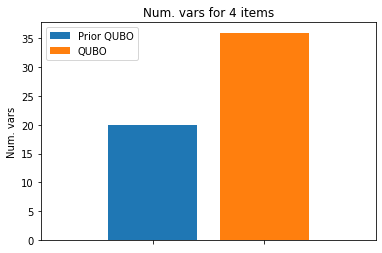

In [4]:
print(f"The number of variables prior converting to QUBO is {qp.get_num_vars()}")
print(f"The number of variables after converting to QUBO is {qubo.get_num_vars()}")

plt.figure()
plt.bar(0, qp.get_num_vars(), label="Prior QUBO")
plt.bar(1, qubo.get_num_vars(), label="QUBO")
plt.xticks(range(2), 2 * [""])
plt.xlim((-1,2))
plt.legend()
plt.ylabel("Num. vars")
plt.title(f"Num. vars for {num_items} items")

In [5]:
def BinPacking(num_items, num_bins, weights, max_weight, simplification=False):
    # Construct model using docplex
    mdl = Model("BinPacking")

    y = mdl.binary_var_list(num_bins, name="y") # list of variables that represent the bins
    x =  mdl.binary_var_matrix(num_items, num_bins, "x") # variables that represent the items on the specific bin

    objective = mdl.sum(y)

    mdl.minimize(objective)

    for i in range(num_items):
        # First set of constraints: the items must be in any bin
        mdl.add_constraint(mdl.sum(x[i, j] for j in range(num_bins)) == 1)

    for j in range(num_bins):
        # Second set of constraints: weight constraints
        mdl.add_constraint(mdl.sum(weights[i] * x[i, j] for i in range(num_items)) <= max_weight * y[j])

    # Load quadratic program from docplex model
    qp = QuadraticProgram()
    qp.from_docplex(mdl)
    if simplification:
        l = int(np.ceil(np.sum(weights)/max_weight))
        qp = qp.substitute_variables({f"y_{_}":1 for _ in range(l)}) # First simplification 
        qp = qp.substitute_variables({"x_0_0":1}) # Assign the first item into the first bin
        qp = qp.substitute_variables({f"x_0_{_}":0 for _ in range(1, num_bins)}) # as the first item is in the first 
                                                                                #bin it couldn't be in the other bins
    qubo = QuadraticProgramToQubo().convert(qp)# Create a converter from quadratic program to qubo representation
    return qubo

After the simplification, the number of variables is 29


Text(0.5, 1.0, 'Num. vars for 4 items')

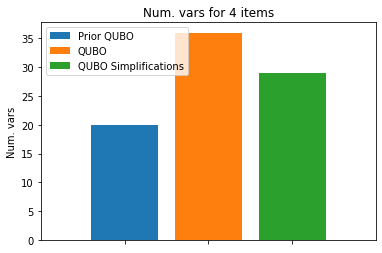

In [6]:
qubo_simp = BinPacking(num_items, num_bins, weights, max_weight, simplification=True)
print(f"After the simplification, the number of variables is {qubo_simp.get_num_vars()}")
plt.figure()
plt.bar(0, qp.get_num_vars(), label="Prior QUBO")
plt.bar(1, qubo.get_num_vars(), label="QUBO")
plt.bar(2, qubo_simp.get_num_vars(), label="QUBO Simplifications")
plt.xticks(range(3), 3 * [""])
plt.xlim((-1,3))
plt.legend()
plt.ylabel("Num. vars")
plt.title(f"Num. vars for {num_items} items")

In [7]:
from qiskit import Aer
backend = Aer.get_backend("qasm_simulator")

In [8]:
def interpret(results, weights, num_items, num_bins, simplify=False):
    """
    Save the results as a list of list where each sublist represent a bin
    and the sublist elements represent the items weights
    
    Args:
    results: results of the optimization
    weights (list): weights of the items
    num_items: (int) number of items
    num_bins: (int) number of bins
    """
    if simplify:
        l = int(np.ceil(np.sum(weights)/max_weight))
        bins = l * [1] + list(results[:num_bins - l])
        items = results[num_bins - l: (num_bins - l) + num_bins * (num_items - 1)].reshape(num_items - 1, num_bins)
        items_in_bins = [[i+1 for i in range(num_items-1) if bins[j] and items[i, j]] for j in range(num_bins)]
        items_in_bins[0].append(0)
    else:
        bins = results[:num_bins]
        items = results[num_bins:(num_bins + 1) * num_items].reshape((num_items, num_bins))
        items_in_bins = [[i for i in range(num_items) if bins[j] and items[i, j]] for j in range(num_bins)]
    return items_in_bins

def get_figure(items_in_bins, weights, max_weight, title=None):
    """Get plot of the solution of the Bin Packing Problem.

    Args:
        result : The calculated result of the problem

    Returns:
        fig: A plot of the solution, where x and y represent the bins and
        sum of the weights respectively.
    """
    colors = plt.cm.get_cmap("jet", len(weights))
    num_bins = len(items_in_bins)
    fig, axes = plt.subplots()
    for _, bin_i in enumerate(items_in_bins):
        sum_items = 0
        for item in bin_i:
            axes.bar(_, weights[item], bottom=sum_items, label=f"Item {item}", color=colors(item))
            sum_items += weights[item]
    axes.hlines(max_weight, -0.5, num_bins - 0.5, linestyle="--", color="tab:red", label="Max Weight")
    axes.set_xticks(np.arange(num_bins))
    axes.set_xlabel("Bin")
    axes.set_ylabel("Weight")
    axes.legend()
    if title:
        axes.set_title(title)
    return fig

The number of qubits is: {2: 9, 3: 20, 4: 29, 5: 40, 6: 56, 7: 70, 8: 92, 9: 109}


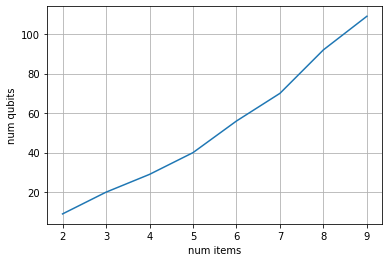

In [9]:
max_weight = 15
num_qubits = {}
for i in range(2, 10):
    num_items = i
    num_bins = num_items
    weights = [np.random.randint(1, max_weight) for _ in range(i)]
    num_qubits[i] = BinPacking(num_items, num_bins, weights, max_weight, simplification=True).get_num_vars()

plt.figure()
plt.plot(num_qubits.keys(), num_qubits.values())
plt.xlabel("num items")
plt.ylabel("num qubits")
plt.grid()
print(f"The number of qubits is: {num_qubits}")

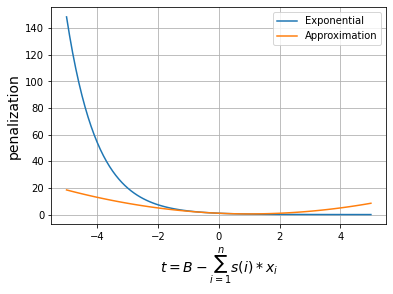

In [10]:
x = np.linspace(-5, 5, 100)
plt.figure()
plt.plot(x, np.exp(-x), label="Exponential")
plt.plot(x, 1 - (x) + (x) ** 2 / 2, label="Approximation")
plt.xlabel(r"$t = B - \sum_{i=1}^n s(i)*x_i$", fontsize=14)
plt.ylabel("penalization", fontsize=14)
plt.grid()
plt.legend()

In [11]:
def BinPackingNewApproach(num_items, num_bins, weights, max_weight, alpha=0.01, simplification=False):
    # Construct model using docplex
    mdl = Model("BinPackingNewApproach")

    y = mdl.binary_var_list(num_bins, name="y") # list of variables that represent the bins
    x =  mdl.binary_var_matrix(num_items, num_bins, "x") # variables that represent the items on the specific bin

    objective = mdl.sum(y)
    
    # PENALIZATION
    penalization = 0
    for j in range(num_bins):
        t = max_weight * y[j] - mdl.sum(weights[i] * x[i, j] for i in range(num_items))
        penalization += -t + t**2 / 2
    mdl.minimize(objective + alpha * penalization)

    for i in range(num_items):
        # First set of constraints: the items must be in any bin
        mdl.add_constraint(mdl.sum(x[i, j] for j in range(num_bins)) == 1)

    # Load quadratic program from docplex model
    qp = QuadraticProgram()
    qp.from_docplex(mdl)
    if simplification:
        l = int(np.ceil(np.sum(weights)/max_weight))
        qp = qp.substitute_variables({f"y_{_}":1 for _ in range(l)}) # First simplification 
        qp = qp.substitute_variables({"x_0_0":1}) # Assign the first item into the first bin
        qp = qp.substitute_variables({f"x_0_{_}":0 for _ in range(1, num_bins)}) # as the first item is in the first 
                                                                                #bin it couldn't be in the other bins
    qubo = QuadraticProgramToQubo().convert(qp)# Create a converter from quadratic program to qubo representation
    return qubo

The number of qubits for the Classical approach is: {2: 7, 3: 18, 4: 29, 5: 43, 6: 57, 7: 70, 8: 91, 9: 112}
The number of qubits is for the new approach is: {2: 2, 3: 7, 4: 14, 5: 23, 6: 33, 7: 45, 8: 59, 9: 76}


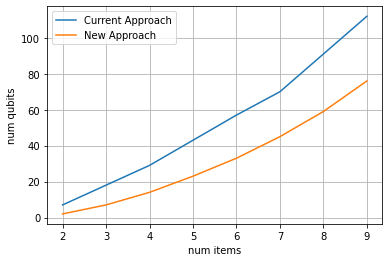

In [12]:
max_weight = 15
num_qubits = {}
num_qubits_new = {}
for i in range(2, 10):
    num_items = i
    num_bins = num_items
    weights = [np.random.randint(1, max_weight) for _ in range(i)]
    num_qubits[i] = BinPacking(num_items, num_bins, weights, max_weight, simplification=True).get_num_vars()
    num_qubits_new[i] = BinPackingNewApproach(num_items, num_bins, weights, max_weight, simplification=True).get_num_vars()
    
plt.figure()
plt.plot(num_qubits.keys(), num_qubits.values(), label="Current Approach")
plt.plot(num_qubits_new.keys(), num_qubits_new.values(), label="New Approach")
plt.xlabel("num items")
plt.ylabel("num qubits")
plt.grid()
plt.legend()
print(f"The number of qubits for the Classical approach is: {num_qubits}")
print(f"The number of qubits is for the new approach is: {num_qubits_new}")



In [13]:
np.random.seed(1)
num_items = 4 # number of items
num_bins = num_items # maximum number of bins
max_weight = 15 # max weight of a bin
weights = np.random.randint(1, max_weight, num_items) # Randomly picking the item weight


#qubo_old = BinPacking(num_items, num_bins, weights, max_weight, simplification=True)
qubo_new = BinPackingNewApproach(num_items, num_bins, weights, max_weight, alpha=0.05, simplification=True)
qaoa = MinimumEigenOptimizer(QAOA(optimizer=COBYLA(maxiter=300), reps=3, quantum_instance=backend))
#result_qaoa_old = qaoa.solve(qubo_old)
result_qaoa_new = qaoa.solve(qubo_new)
#result_ideal_old = CplexOptimizer().solve(qubo_old)

In [14]:
#print("Solving QUBO using QAOA Classical Approach")
#print(result_qaoa_old)
print("Solving QUBO using QAOA New Approach")
print(result_qaoa_new)
#print("Solving QUBO using CPLEX")
#print(result_ideal_old)

Solving QUBO using QAOA New Approach
optimal function value: 3.0750000000000455
optimal value: [0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
status: SUCCESS


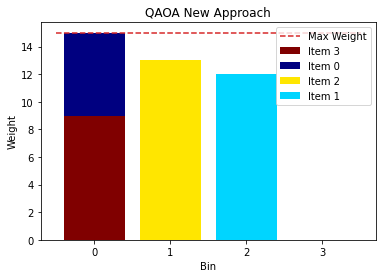

In [15]:
fig = get_figure(interpret(result_qaoa_new.x, weights, num_items, num_bins, simplify=True), weights, max_weight, title="QAOA New Approach")

In [16]:
solutions_new = []


for _ in range(10):
    result_qaoa_new = qaoa.solve(qubo_new)
    solutions_new.append(result_qaoa_new.fval)


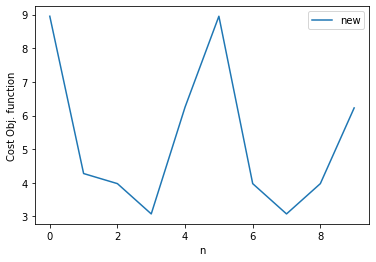

In [17]:
plt.figure()
plt.plot(solutions_new, label="new")
plt.xlabel("n")
plt.ylabel("Cost Obj. function")
plt.legend()

# Another solution
With graph value (-2, 2)

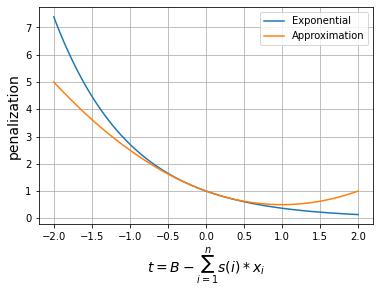

In [18]:
x = np.linspace(-2, 2, 100)
plt.figure()
plt.plot(x, np.exp(-x), label="Exponential")
plt.plot(x, 1 - (x) + (x) ** 2 / 2, label="Approximation")
plt.xlabel(r"$t = B - \sum_{i=1}^n s(i)*x_i$", fontsize=14)
plt.ylabel("penalization", fontsize=14)
plt.grid()
plt.legend()

In [19]:
np.random.seed(1)
num_items = 4 # number of items
num_bins = num_items # maximum number of bins
max_weight = 15 # max weight of a bin
weights = np.random.randint(1, max_weight, num_items) # Randomly picking the item weight


#qubo_old = BinPacking(num_items, num_bins, weights, max_weight, simplification=True)
qubo_new = BinPackingNewApproach(num_items, num_bins, weights, max_weight, alpha=0.05, simplification=True)
qaoa = MinimumEigenOptimizer(QAOA(optimizer=COBYLA(maxiter=300), reps=3, quantum_instance=backend))
#result_qaoa_old = qaoa.solve(qubo_old)
result_qaoa_new = qaoa.solve(qubo_new)
#result_ideal_old = CplexOptimizer().solve(qubo_old)

In [14]:
#print("Solving QUBO using QAOA Classical Approach")
#print(result_qaoa_old)
print("Solving QUBO using QAOA New Approach")
print(result_qaoa_new)
#print("Solving QUBO using CPLEX")
#print(result_ideal_old)

Solving QUBO using QAOA New Approach
optimal function value: 6.25
optimal value: [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
status: SUCCESS


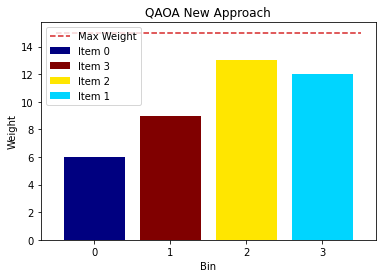

In [15]:
#fig = get_figure(interpret(result_ideal_old.x, weights, num_items, num_bins, simplify=True), weights, max_weight, title="CPLEX")
#fig = get_figure(interpret(result_qaoa_old.x, weights, num_items, num_bins, simplify=True), weights, max_weight, title="QAOA classical approach")
fig = get_figure(interpret(result_qaoa_new.x, weights, num_items, num_bins, simplify=True), weights, max_weight, title="QAOA New Approach")

In [16]:
#-2,2
solutions_new = []


for _ in range(10):
    result_qaoa_new = qaoa.solve(qubo_new)
    solutions_new.append(result_qaoa_new.fval)


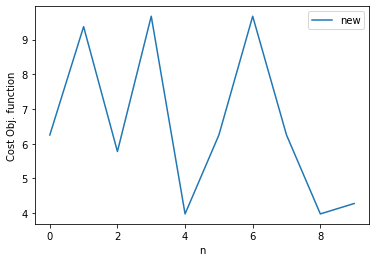

In [17]:
plt.figure()
plt.plot(solutions_new, label="new")
plt.xlabel("n")
plt.ylabel("Cost Obj. function")
plt.legend()